# BERT Sentiment classification with BERT model - ImDB dataset

Welcome in this notebook ! We are here to learn how to play with HuggingFace model. Let's begin with a simple application : sentiment classification with a BERT.


We use a BERT tokekenizer + BERT encoder and then train a classification MLP head on the top.

![image-2.png](attachment:image-2.png)

## Import

In [107]:
from transformers import BertForSequenceClassification, BertTokenizer
from datasets import load_dataset, Dataset, DatasetDict
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from torch.utils.data import TensorDataset, RandomSampler, DataLoader
from torch.optim import AdamW
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

## General parameters

In [108]:
BATCH_SIZE= 1
EPOCHS = 5
R1 = 0.8 #ratio train set

## Data Visualisation

The IMDB dataset is a widely-used resource for sentiment classification tasks in natural language processing (NLP). It consists of 50,000 movie reviews from the Internet Movie Database (IMDB), evenly split into 25,000 training and 25,000 testing reviews. Each subset contains an equal number of positive (12,500) and negative (12,500) reviews, labeled with binary sentiment labels (positive: 1, negative: 0). The reviews are written in English and vary in length.

In [109]:
imdb = load_dataset("imdb")

In [110]:
print(f"List of split available in the imdb dataset: {imdb.keys()}")

List of split available in the imdb dataset: dict_keys(['train', 'test', 'unsupervised'])


### Split dataset

In [111]:
split = imdb["train"].train_test_split(train_size=R1, seed=42)
train, val = split["train"], split["test"]
test = imdb["test"]

In [129]:
dataset = DatasetDict({"train" : train,
                       "val" : val,
                      "test": test})

### Length distribution

In [113]:
train_len = train.map(lambda example : {"len": len(example["text"])}, remove_columns=train.column_names)
val_len = val.map(lambda example : {"len": len(example["text"])}, remove_columns=val.column_names)
test_len = test.map(lambda example: {"len": len(example["text"])}, remove_columns=test.column_names)

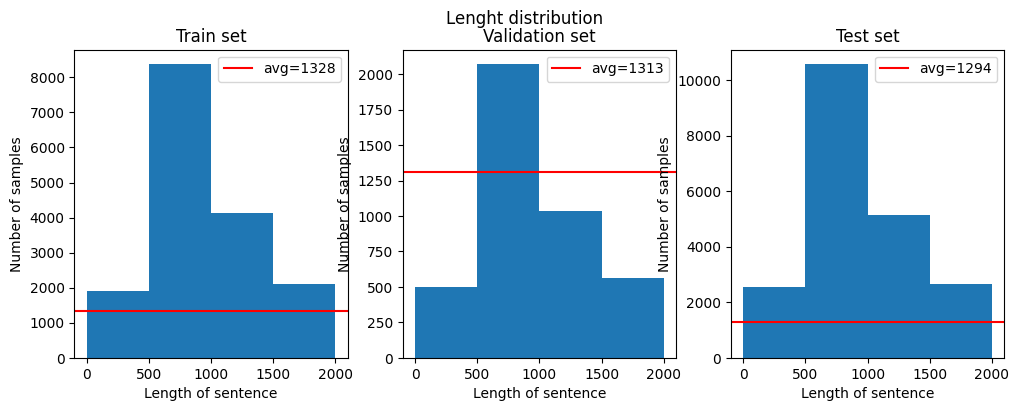

In [114]:
fig, axes = plt.subplots(1,3, figsize=(12,4))
fig.suptitle("Lenght distribution")

axes[0].set_title("Train set")
axes[0].hist(train_len["len"], bins=[0,500,1000,1500,2000])
avg = sum(train_len["len"])/len(train_len["len"])
axes[0].axhline(avg, color="r", label=f"avg={avg:.0f}")
axes[0].set_xlabel("Length of sentence")
axes[0].set_ylabel("Number of samples")
axes[0].legend()

axes[1].set_title("Validation set")
axes[1].hist(val_len["len"], bins=[0,500,1000,1500,2000])
avg = sum(val_len["len"])/len(val_len["len"])
axes[1].axhline(avg, color="r", label=f"avg={avg:.0f}")
axes[1].set_xlabel("Length of sentence")
axes[1].set_ylabel("Number of samples")
axes[1].legend()

axes[2].set_title("Test set")
axes[2].hist(test_len["len"], bins=[0,500,1000,1500,2000])
avg = sum(test_len["len"])/len(test_len["len"])
axes[2].axhline(avg, color="r", label=f"avg={avg:.0f}")
axes[2].set_xlabel("Length of sentence")
axes[2].set_ylabel("Number of samples")
axes[2].legend()

plt.show()

### Labels distribution

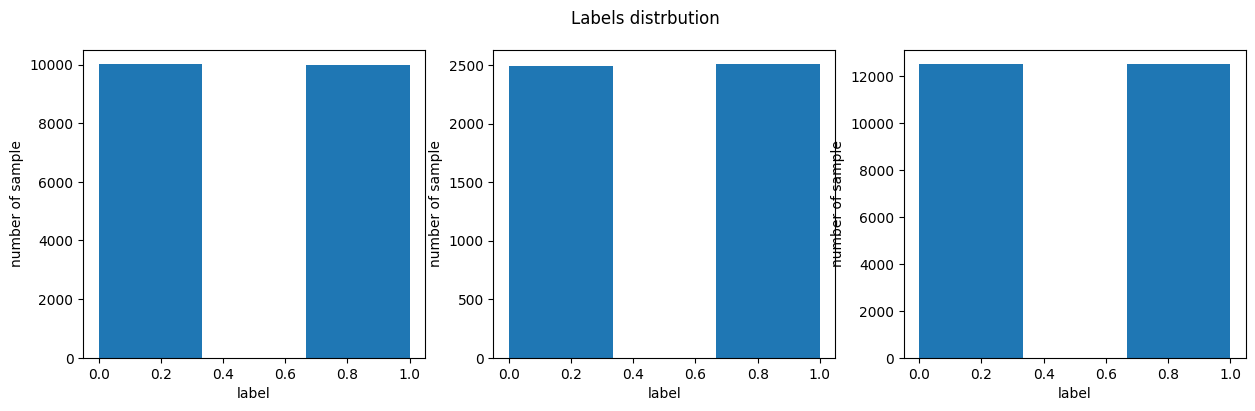

In [115]:
fig, axes = plt.subplots(1,3, figsize=(15,4))
fig.suptitle("Labels distrbution")
axes[0].hist(train["label"], bins=3)
axes[0].set_xlabel("label")
axes[0].set_ylabel("number of sample")

axes[1].hist(val["label"], bins=3)
axes[1].set_xlabel("label")
axes[1].set_ylabel("number of sample")

axes[2].hist(test["label"], bins=3)
axes[2].set_xlabel("label")
axes[2].set_ylabel("number of sample")
plt.show()

## Class

In [116]:
class Classifier() :
    """
    This class defines a text classifier based on a Bert Model.
    The architecture is composed of a Bert and an MLP head on the top.
    Here we instanciate it in order to perform a sentiment classification task.
    """
    def __init__(self, tokenizer, optimizer, dataset, model) :
        """
        Inputs :\n
        tokenizer: the tokenizer used on a the text\n
        optimizer : the optimizer used for the training\n
        dataset : all data (train+test+val)\n
        model : instance of the pytorch model
        """
        self.tokenizer = tokenizer
        self.dataset = dataset
        self.optimizer = optimizer
        self.model = model

        self.train_dataloader = None
        self.val_dataloader = None
        self.test_dataloader = None

        self.train_label = None
        self.val_label = None
        self.test_label = None

        self.train_loss = []
        self.val_loss = []
        self.test_loss = []

        self.train_accur = []
        self.val_accur = []
        self.test_accur = []

    def preprocess(self) :
        """
        This function tokenenizes examples over each set.
        Then each set are convert into dataloader with a RandomSampler and batch_size=BATCH_SIZE
        """
        #Split
        train = self.dataset["train"].shuffle(seed=42)
        val = self.dataset["val"].shuffle(seed=42)
        test = self.dataset["test"].shuffle(seed=42)

        #Tokenize
        train_tk = self.tokenizer(train["text"], padding=True, return_tensors="pt", truncation=True)
        val_tk = self.tokenizer(val["text"], padding=True, return_tensors="pt", truncation=True)
        test_tk = self.tokenizer(test["text"], padding=True, return_tensors="pt", truncation=True)

        #Labels
        self.train_label = torch.tensor(train["label"])
        self.val_label = torch.tensor(val["label"])
        self.test_label = torch.tensor(test["label"])

        #TensorDataset
        train_tensor = TensorDataset(train_tk["input_ids"], train_tk["attention_mask"], self.train_label)
        val_tensor = TensorDataset(val_tk["input_ids"], val_tk["attention_mask"], self.val_label)
        test_tensor = TensorDataset(test_tk["input_ids"], test_tk["attention_mask"], self.test_label)

        #DataLoader
        self.train_dataloader = DataLoader(train_tensor, sampler=RandomSampler(train_tensor), batch_size=BATCH_SIZE)
        self.val_dataloader = DataLoader(val_tensor, sampler=RandomSampler(val_tensor), batch_size=BATCH_SIZE)
        self.test_dataloader = DataLoader(test_tensor, sampler=RandomSampler(test_tensor), batch_size=BATCH_SIZE)

#One training epoch
    def one_epoch_train(self, epoch:int, device:str) :
        """
        This function performs one train epoch on a specified device.
        It performs backprop for each sample and optimize the model with the self.optimizer.
        Inputs :
        epoch: int, number of current epoch
        device: str, cpu ou gpu
        """
        self.model.train()
        train_loss = 0
        all_preds = torch.tensor([])
        #Train on each batch
        for batch in self.train_dataloader :
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            self.optimizer.zero_grad()
            outputs = self.model(input_ids = input_ids, attention_mask = attention_mask, labels = labels)
            all_preds = torch.cat((all_preds, torch.argmax(outputs.logits, dim=1).to("cpu")))
            loss = outputs.loss
            loss.backward()

            self.optimizer.step()
            train_loss += loss.item()

        #Computes and displays metrics
        avg_train_loss = train_loss / len(self.train_dataloader)
        train_accur = accuracy_score(self.train_label, all_preds)
        print(f"Epoch {epoch + 1}/{EPOCHS} - Training loss: {avg_train_loss} - Accuracy: {train_accur}")
        self.train_loss.append(avg_train_loss)
        self.train_accur.append(train_accur)

#One validation epoch
    def one_epoch_val(self, epoch, device) :
        """
        This function performs a validation epoch on a specified device.
        It computes the loss and accuracy value for the current epoch.
        """
        self.model.eval()
        eval_loss = 0
        all_preds = torch.tensor([])
        with torch.no_grad() :
            for batch in self.val_dataloader :
                input_ids = batch[0].to(device)
                attention_mask = batch[1].to(device)
                labels = batch[2].to(device)

                outputs = self.model(input_ids = input_ids, attention_mask = attention_mask, labels = labels)
                all_preds = torch.cat((all_preds, torch.argmax(outputs.logits, dim=1).to("cpu")))
                loss = outputs.loss
                eval_loss += loss.item()
        avg_val_loss = eval_loss / len(self.val_dataloader)
        val_accur = accuracy_score(all_preds, self.val_label)
        print(f"Epoch {epoch + 1}/{EPOCHS} - Validation loss: {avg_val_loss} - accuracy: {val_accur}")
        self.val_loss.append(avg_val_loss)
        self.val_accur.append(val_accur)

#One test epoch
    def test(self, device) :
        self.model.eval()
        test_loss = 0
        all_preds = torch.tensor([])
        with torch.no_grad() :
            for batch in self.test_dataloader :
                input_ids = batch[0].to(device)
                attention_mask = batch[0].to(device)
                labels = batch[2].to(device)
                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                all_preds = torch.cat((all_preds, torch.argmax(outputs.logits, dim=1).to("cpu")))
                test_loss += outputs.loss.item()

        avg_test_loss = test_loss/len(self.test_dataloader)
        test_accur = accuracy_score(self.test_label, all_preds)

        print(f"Validation loss: {avg_test_loss} - accuracy: {test_accur}")
        sns.heatmap(confusion_matrix(self.test_label, all_preds), cmap="Blues", annot=True, fmt="d")
        self.val_loss.append(avg_test_loss)
        self.val_accur.append(test_accur)


    def train(self) :
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"device used : {device}")
        self.model.to(device)

        for epoch in range(EPOCHS) :
            self.one_epoch_train(epoch, device)
            self.one_epoch_val(epoch, device)

    def graph(self) :
        fig, axes = plt.subplots(1,2, figsize=(10,7))
        plt.suptitle("Loss graph")
        axes[0].plot(range(EPOCHS), self.train_loss)
        axes[0].set_title("Train loss")
        axes[0].set_xlabel("epoch")
        axes[0].set_ylabel("training loss")

        axes[1].plot(range(EPOCHS), self.val_loss)
        axes[1].set_title("validation loss")
        axes[1].set_xlabel("epoch")
        axes[1].set_ylabel("validation loss")

In [117]:
class EarlyStopper() :
    pass

## Example with a sample of the ImdB dataset

In [118]:
imdb["train"][:9]

{'text': ['I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far b

In [135]:
train_example = Dataset.from_dict(imdb["train"][:500])
val_example = Dataset.from_dict(imdb["train"][500:800])
test_example = Dataset.from_dict(imdb["test"][:300])

In [136]:
train_example.shuffle()

Dataset({
    features: ['text', 'label'],
    num_rows: 500
})

In [137]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
optimizer = AdamW(model.parameters(), lr=10e-5)
dataset_example = DatasetDict({"train" : train_example,
                       "val" : val_example,
                      "test": test_example})

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\alexa\Desktop\myara.github.io\gitenv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [138]:
cls = Classifier(tokenizer, optimizer, dataset_example, model)

In [139]:
cls.preprocess()

In [140]:
cls.train()

device used : cpu
Epoch 1/5 - Training loss: 0.004754507371275395 - Accuracy: 1.0
Epoch 1/5 - Validation loss: 2.7078816219727742e-05 - accuracy: 1.0
Epoch 2/5 - Training loss: 2.3165160479038606e-05 - Accuracy: 1.0
Epoch 2/5 - Validation loss: 1.1483364536009807e-05 - accuracy: 1.0
Epoch 3/5 - Training loss: 1.1684582465022686e-05 - Accuracy: 1.0
Epoch 3/5 - Validation loss: 6.555297260698959e-06 - accuracy: 1.0
Epoch 4/5 - Training loss: 7.2073660071509945e-06 - Accuracy: 1.0
Epoch 4/5 - Validation loss: 4.299075129286697e-06 - accuracy: 1.0
Epoch 5/5 - Training loss: 4.884706746906886e-06 - Accuracy: 1.0
Epoch 5/5 - Validation loss: 2.990559189584019e-06 - accuracy: 1.0


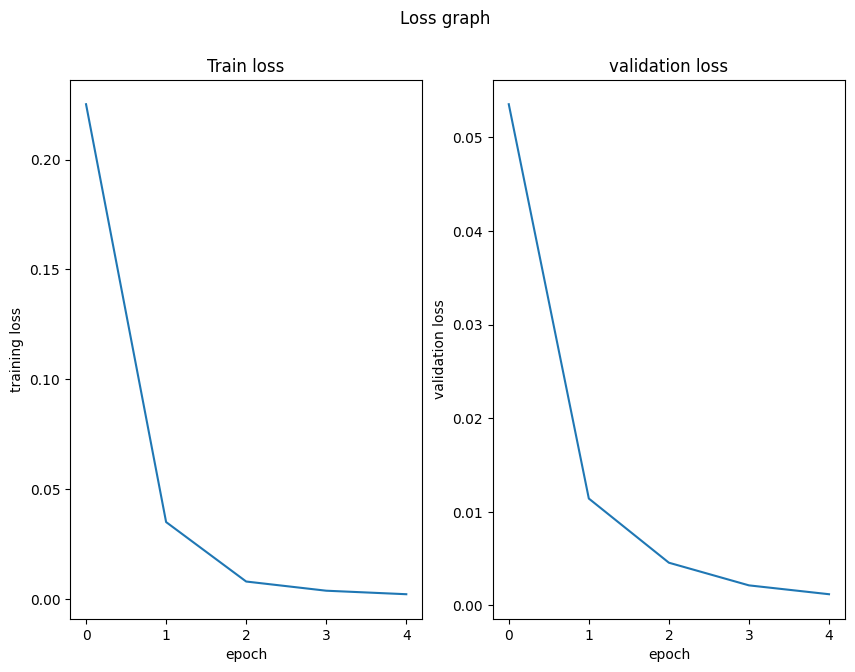

In [130]:
cls.graph()

In [131]:
cls.model.eval()
encoded = cls.tokenizer("Hey it's a very good movie", truncation=True, padding=True, return_tensors="pt")

In [132]:
with torch.no_grad() :
    outputs = cls.model(input_ids = encoded["input_ids"], attention_mask=encoded["attention_mask"])

In [133]:
outputs.logits

tensor([[ 3.3388, -3.1582]])

In [134]:
classe =  np.argmax(outputs.logits.numpy()[0])
if classe == 1 : print("good")
else : print("bad")

bad
